# Multi-class Classification with CNNs: cifar-10

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets

import datetime

notebook_start_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_start_time}")

2025-04-28 00:11:57.642635: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 00:11:57.677951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745813517.725314  243769 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745813517.738976  243769 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745813517.777582  243769 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Notebook last run (end-to-end): 2025-04-28 00:12:01.579670


In [2]:
cifar_10 = datasets.cifar10.load_data()
(X_train, y_train), (X_test, y_test) = cifar_10
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
print(f"{X_train.shape = }\n{y_train.shape = }\n{X_test.shape = }\n{y_test.shape = }")

X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 1)
X_test.shape = (10000, 32, 32, 3)
y_test.shape = (10000, 1)


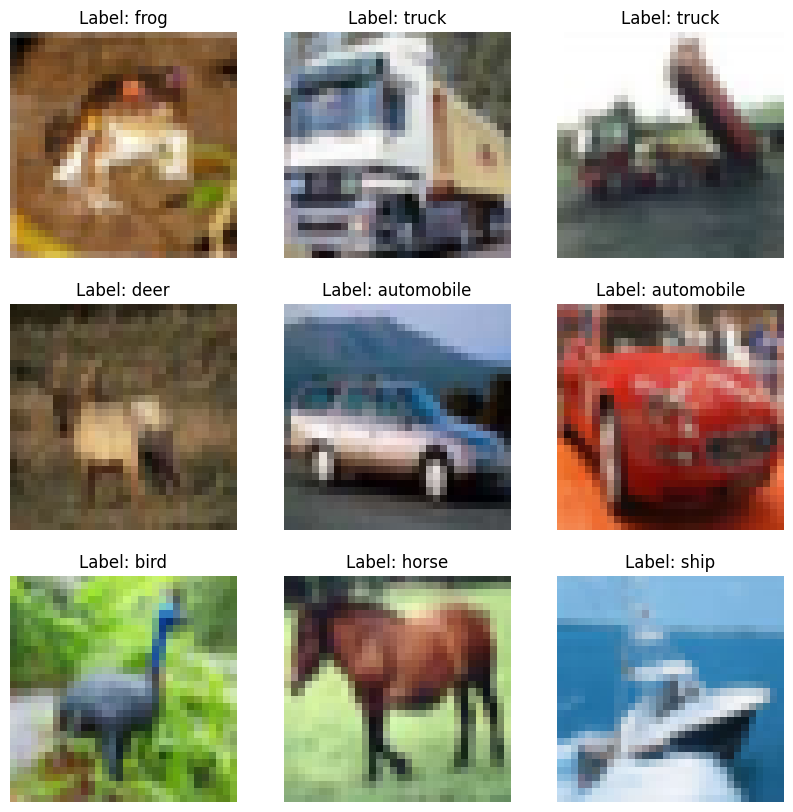

In [3]:
# Display a few images from the dataset
def display_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {classes[labels[i][0]]}")
        plt.axis("off")
    plt.show()
display_images(X_train[:9], y_train[:9])

In [4]:
def plot_confusion_matrix(y_true, X_test, model, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(classes))
    cm = cm.numpy()
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def get_class_training_weights(train_ds, normalize = True):
    labels, counts = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
    total = sum(counts)

    weights = [total/(2*count) for count in counts]
    max_weight = np.max(weights)

    if normalize:
        return {l : weights[i]/max_weight for i, l in enumerate(labels)}

    return {l : weights[i] for i, l in enumerate(labels)}

class_weight = get_class_training_weights(train_ds=cifar_10)
for class_id, weight in class_weight.items():
    print(f"Class {classes[int(class_id)]}: {weight:.2f}")

Class airplane: 1.00
Class automobile: 1.00
Class bird: 1.00
Class cat: 1.00
Class deer: 1.00
Class dog: 1.00
Class frog: 1.00
Class horse: 1.00
Class ship: 1.00
Class truck: 1.00


In [5]:
from dataclasses import dataclass

class ModelBuilder:

    _input_shape = (32, 32, 3)
    _optimizer: tf.keras.Optimizer = None
    _layers_augmentation: list[tf.keras.Layer] = []
    _learning_rate: float = 1e-4
    _loss: tf.keras.Loss = None
    _metrics: list[tf.keras.Metric] = None
    _classes = 10

    def build(self, core_layers: list[tf.keras.Layer], name = "") -> tf.keras.models.Sequential:
        if self._optimizer is None:
            self._optimizer = tf.keras.optimizers.AdamW(learning_rate=self._learning_rate)

        if self._loss is None:
            if self._classes == 2:
                self._loss = tf.keras.losses.BinaryCrossentropy()
            else:
                self._loss = tf.keras.losses.SparseCategoricalCrossentropy()

        if self._metrics is None:
            self._metrics = [
                #tf.keras.metrics.TruePositives(name='tp'),
                #tf.keras.metrics.TrueNegatives(name='tn'),
                #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_accuracy'),
            ]

        model = tf.keras.models.Sequential(name=name)

        model.add(tf.keras.layers.InputLayer(self._input_shape, name="input"))

        for layer in self._layers_augmentation:
            model.add(layer)

        model.add(tf.keras.layers.Rescaling(1./255, name="rescale"))
        for layer in core_layers:
            model.add(layer)
        if self._classes == 2:
            output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")
        else:
            output = tf.keras.layers.Dense(self._classes, activation="softmax", name="output")
        model.add(output)
        model.compile(
            optimizer=self._optimizer,
            loss=self._loss,
            metrics=self._metrics
        )
        return model

    def loss(self, loss):
        """Loss function"""
        self._loss = loss
        return self

    def metrics(self, metrics):
        self._metrics = metrics
        return self

    def optimizer(self, optimizer):
        self._optimizer = optimizer
        return self

    def learning_rate(self, learning_rate):
        if self._optimizer is not None:
            raise Exception("Learning rate was specified after optimizer. Specify only the optimizer or only the learning rate")
        self._learning_rate = learning_rate
        return self

    def augmentation(self, layers: list[tf.keras.Layer] = None):
        if layers is None or not layers:
            layers = [
                tf.keras.layers.RandomFlip("horizontal", name="0.1rflip"),
                tf.keras.layers.RandomRotation(0.2, name="0.2rrot"),
                tf.keras.layers.RandomBrightness(0.2, name="0.3rbright"),
                tf.keras.layers.RandomContrast(0.2, name="0.4rcont"),
            ]
        self._layers_augmentation = layers
        return self

## Training

In [10]:
# first (not really serious) attempt with just a dense neural net
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, name="rescale"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 112s 71ms/step - loss: 1.8784 - sparse_categorical_accuracy: 0.3235 - val_loss: 1.6226 - val_sparse_categorical_accuracy: 0.4277
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 158s 81ms/step - loss: 1.5960 - sparse_categorical_accuracy: 0.4317 - val_loss: 1.5682 - val_sparse_categorical_accuracy: 0.4380
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - loss: 1.4935 - sparse_categorical_accuracy: 0.4675 - val_loss: 1.4649 - val_sparse_categorical_accuracy: 0.4794
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 123s 79ms/step - loss: 1.4180 - sparse_categorical_accuracy: 0.4970 - val_loss: 1.4327 - val_sparse_categorical_accuracy: 0.4875
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 135s 86ms/step - loss: 1.3616 - sparse_categorical_accuracy: 0.5195 - val_loss: 1.4050 - val_sparse_categorical_accuracy: 0.5035
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 147s 94ms/step - loss: 1.3072 - sparse_categorical_accuracy: 0.5390 - val_loss: 1.3851 - val_sparse_cat

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


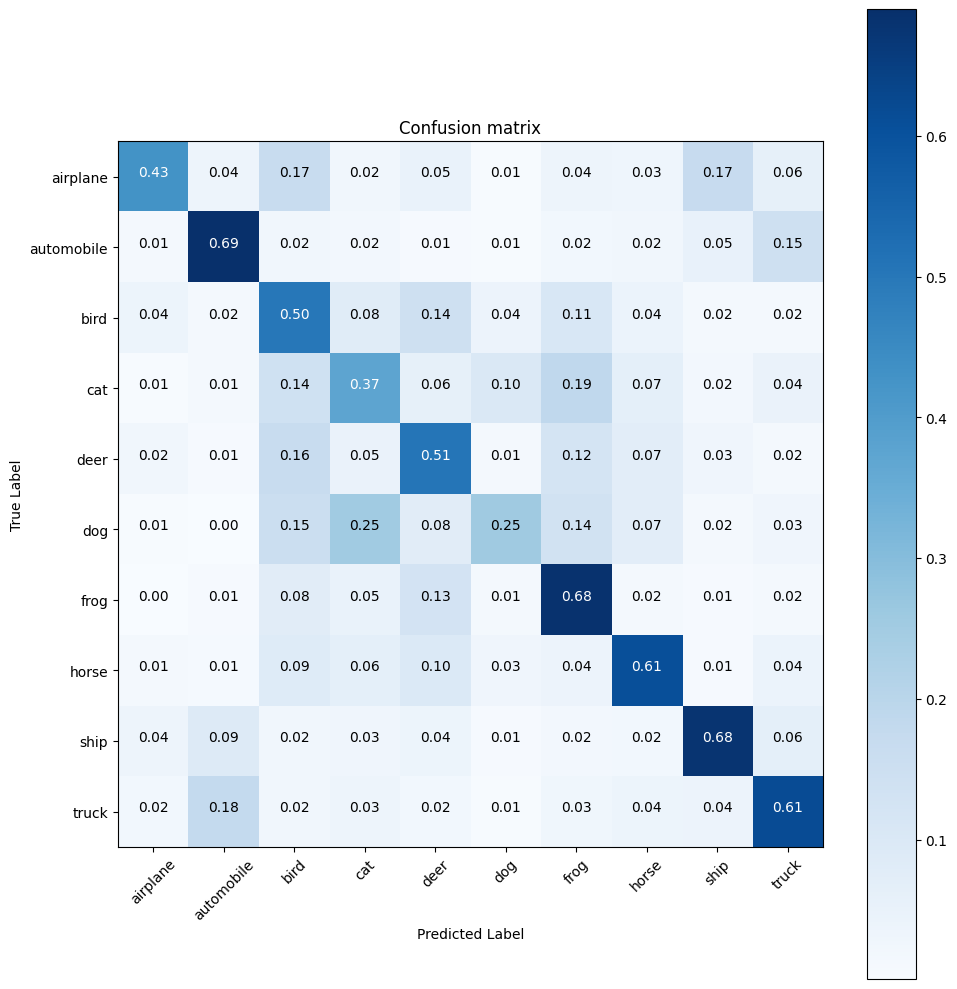

In [11]:
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - loss: 1.9628 - sparse_accuracy: 0.2891 - val_loss: 1.5383 - val_sparse_accuracy: 0.4511
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - loss: 1.4992 - sparse_accuracy: 0.4747 - val_loss: 1.3628 - val_sparse_accuracy: 0.5223
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - loss: 1.3483 - sparse_accuracy: 0.5271 - val_loss: 1.2857 - val_sparse_accuracy: 0.5495
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - loss: 1.2562 - sparse_accuracy: 0.5608 - val_loss: 1.2051 - val_sparse_accuracy: 0.5814
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - loss: 1.1853 - sparse_accuracy: 0.5840 - val_loss: 1.1656 - val_sparse_accuracy: 0.5895
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - loss: 1.1424 - sparse_accuracy: 0.6058 - val_loss: 1.1526 - val_sparse_accuracy: 0.5983
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - loss: 1.1007 - sparse_accuracy: 0.6206 - val_loss: 1.0868 - val_sp

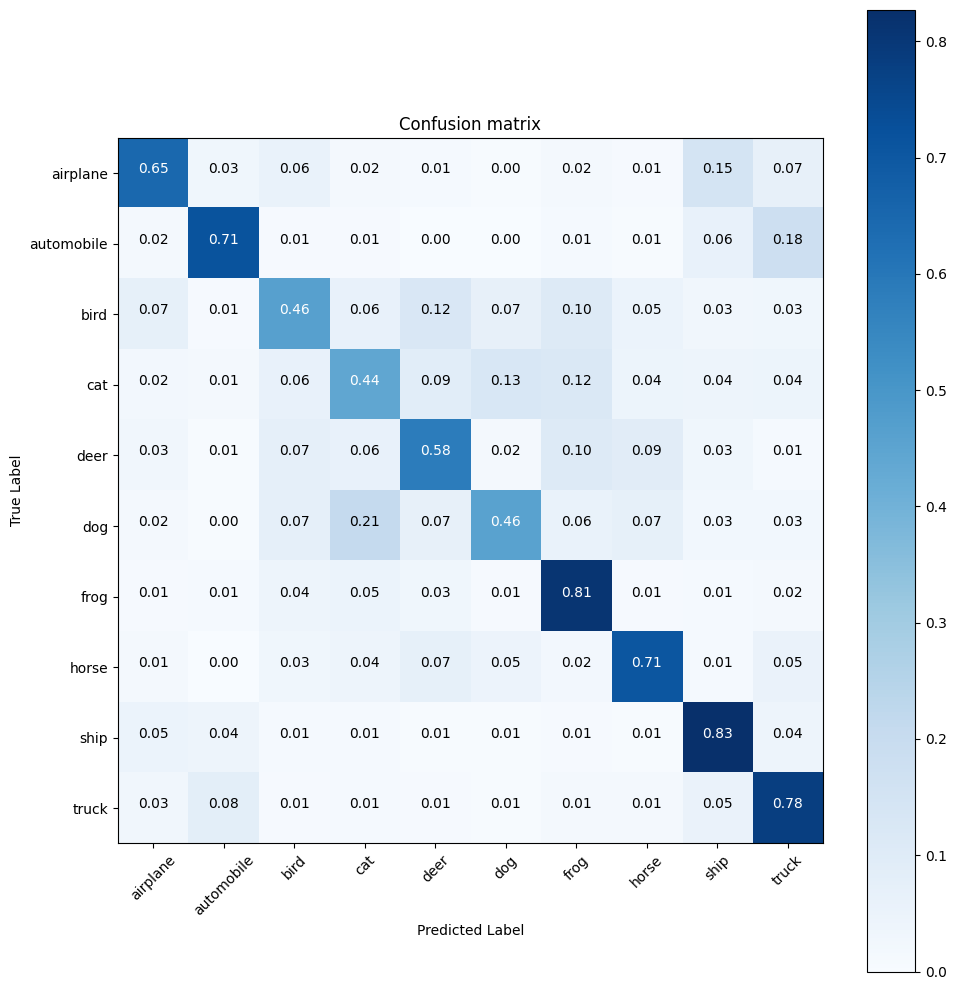

In [12]:
# "real" attempts start here
model_count = 1
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(64, activation='relu'),
]

model = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
)
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 109s 69ms/step - loss: 1.8681 - sparse_accuracy: 0.3208 - val_loss: 1.4440 - val_sparse_accuracy: 0.4731
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 111s 71ms/step - loss: 1.3596 - sparse_accuracy: 0.5112 - val_loss: 1.2923 - val_sparse_accuracy: 0.5364
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 111s 71ms/step - loss: 1.1938 - sparse_accuracy: 0.5761 - val_loss: 1.1053 - val_sparse_accuracy: 0.6126
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 92s 59ms/step - loss: 1.0849 - sparse_accuracy: 0.6184 - val_loss: 1.0507 - val_sparse_accuracy: 0.6289
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 93s 60ms/step - loss: 1.0044 - sparse_accuracy: 0.6489 - val_loss: 1.0354 - val_sparse_accuracy: 0.6394
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 93s 60ms/step - loss: 0.9283 - sparse_accuracy: 0.6787 - val_loss: 0.9544 - val_sparse_accuracy: 0.6693
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 89s 57ms/step - loss: 0.8577 - sparse_accuracy: 0.7011 - val_loss: 0.9243 - val

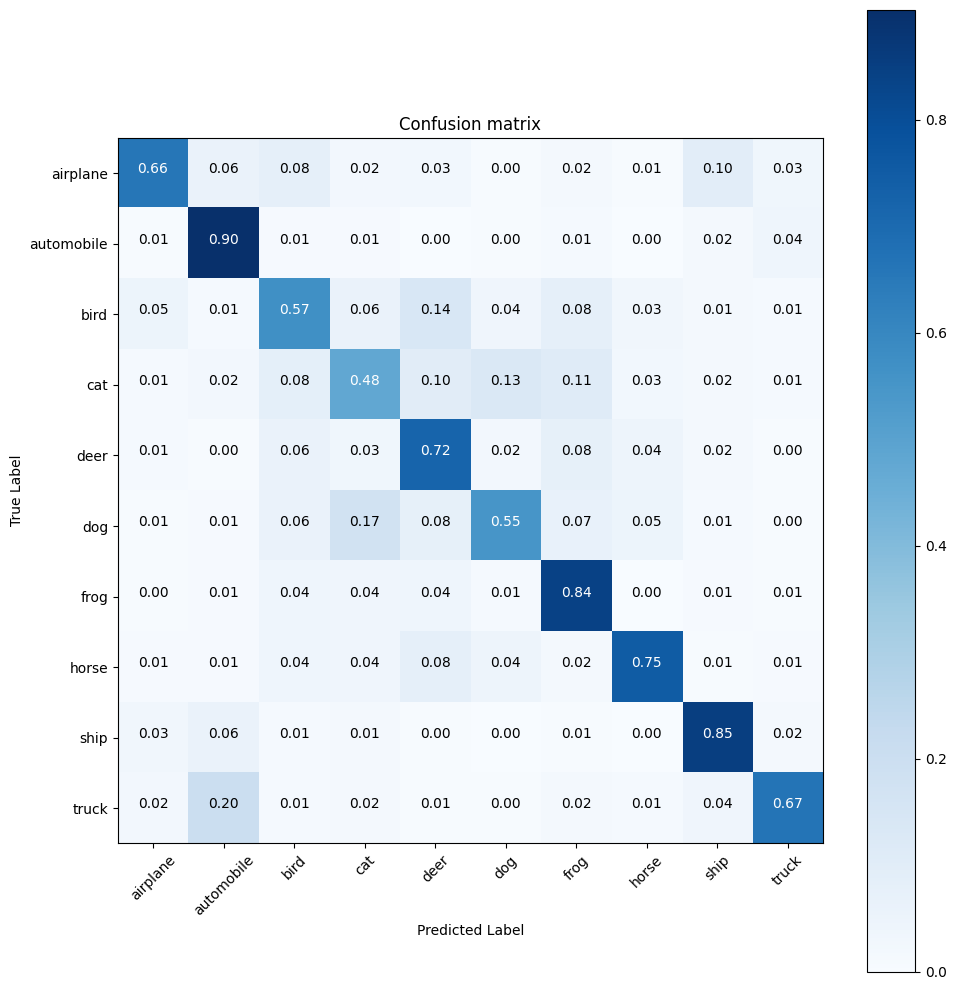

In [14]:
model_count += 1
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
]

model = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
)
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 115s 72ms/step - loss: 2.3026 - sparse_accuracy: 0.0997 - val_loss: 2.3026 - val_sparse_accuracy: 0.1000
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 106s 68ms/step - loss: 2.3026 - sparse_accuracy: 0.0992 - val_loss: 2.3026 - val_sparse_accuracy: 0.1000
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - loss: 2.3026 - sparse_accuracy: 0.1002 - val_loss: 2.3026 - val_sparse_accuracy: 0.1000
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - loss: 2.3026 - sparse_accuracy: 0.0985 - val_loss: 2.3026 - val_sparse_accuracy: 0.1000
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 100s 64ms/step - loss: 2.3026 - sparse_accuracy: 0.0996 - val_loss: 2.3026 - val_sparse_accuracy: 0.1000
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 64ms/step - loss: 2.3026 - sparse_accuracy: 0.0988 - val_loss: 2.3026 - val_sparse_accuracy: 0.1000
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 64ms/step - loss: 2.3026 - sparse_accuracy: 0.1001 - val_loss: 2.3026 - val

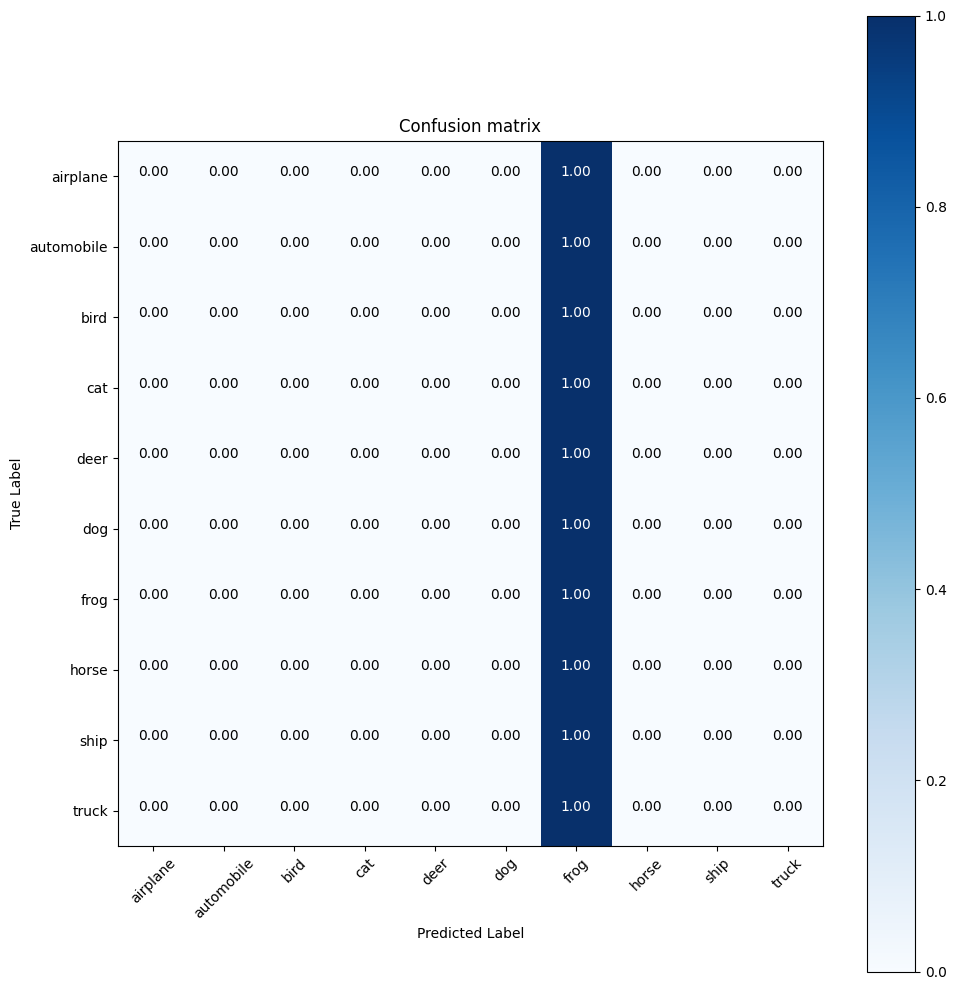

In [15]:
model_count += 1
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
]

model = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
)
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 101s 64ms/step - loss: 2.0731 - sparse_accuracy: 0.2244 - val_loss: 1.6217 - val_sparse_accuracy: 0.4137
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 64ms/step - loss: 1.5644 - sparse_accuracy: 0.4351 - val_loss: 1.4734 - val_sparse_accuracy: 0.4657
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - loss: 1.4439 - sparse_accuracy: 0.4854 - val_loss: 1.4177 - val_sparse_accuracy: 0.4905
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - loss: 1.3641 - sparse_accuracy: 0.5082 - val_loss: 1.3225 - val_sparse_accuracy: 0.5259
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - loss: 1.2942 - sparse_accuracy: 0.5385 - val_loss: 1.2524 - val_sparse_accuracy: 0.5538
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 105s 67ms/step - loss: 1.2266 - sparse_accuracy: 0.5621 - val_loss: 1.2051 - val_sparse_accuracy: 0.5698
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 114s 73ms/step - loss: 1.1709 - sparse_accuracy: 0.5832 - val_loss: 1.1559 - val

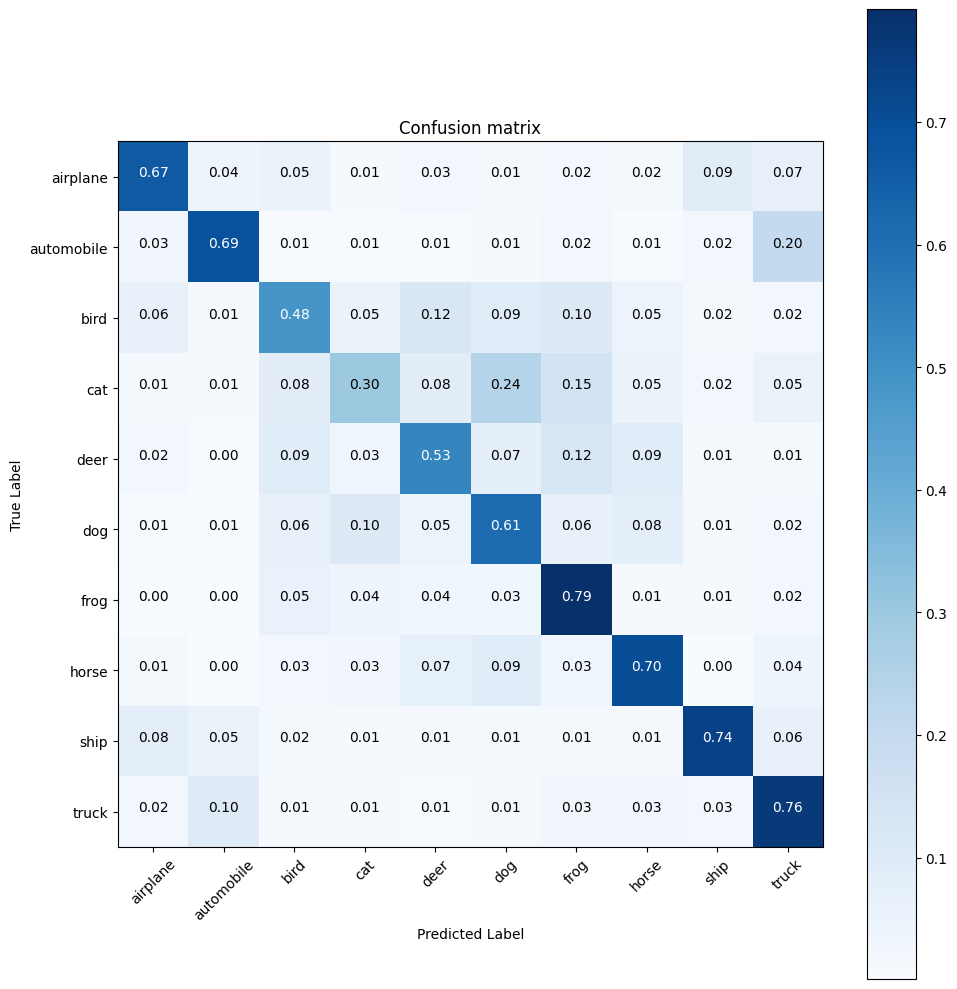

In [16]:
# absolutely no clue what happened there
model_count += 1
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
]

model = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
)
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 147s 93ms/step - loss: 1.8487 - sparse_accuracy: 0.3130 - val_loss: 1.4596 - val_sparse_accuracy: 0.4816
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - loss: 1.3422 - sparse_accuracy: 0.5181 - val_loss: 1.2508 - val_sparse_accuracy: 0.5420
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 92ms/step - loss: 1.1784 - sparse_accuracy: 0.5767 - val_loss: 1.0980 - val_sparse_accuracy: 0.6109
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 139s 89ms/step - loss: 1.0526 - sparse_accuracy: 0.6261 - val_loss: 1.0433 - val_sparse_accuracy: 0.6269
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 135s 87ms/step - loss: 0.9506 - sparse_accuracy: 0.6656 - val_loss: 0.9486 - val_sparse_accuracy: 0.6647
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 136s 87ms/step - loss: 0.8568 - sparse_accuracy: 0.7012 - val_loss: 0.9253 - val_sparse_accuracy: 0.6733
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 135s 86ms/step - loss: 0.7797 - sparse_accuracy: 0.7249 - val_loss: 0.8667 -

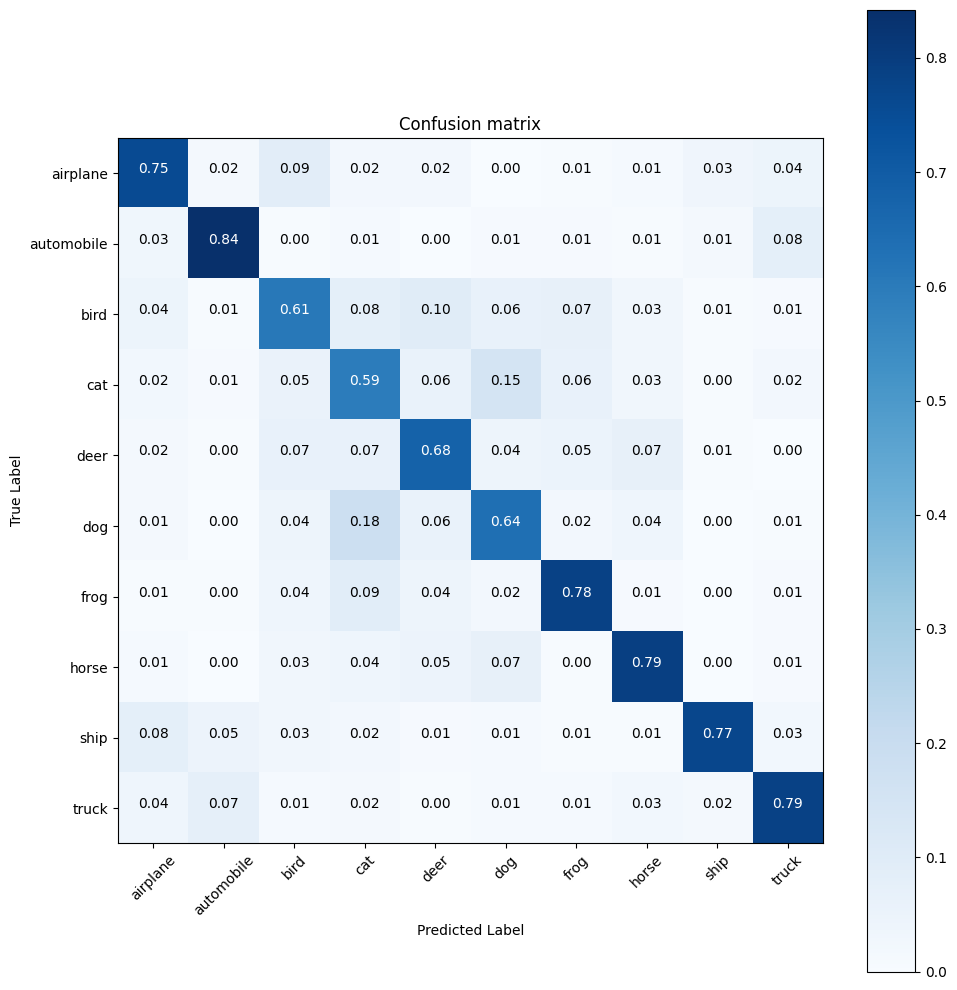

In [17]:
model_count += 1
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
]

model = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
)
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 47ms/step - loss: 1.6597 - sparse_accuracy: 0.4016 - val_loss: 1.2379 - val_sparse_accuracy: 0.5568
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 85s 54ms/step - loss: 1.1143 - sparse_accuracy: 0.6027 - val_loss: 1.0887 - val_sparse_accuracy: 0.6146
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 85s 54ms/step - loss: 0.9111 - sparse_accuracy: 0.6772 - val_loss: 1.0334 - val_sparse_accuracy: 0.6319
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 53ms/step - loss: 0.7546 - sparse_accuracy: 0.7371 - val_loss: 1.0273 - val_sparse_accuracy: 0.6462
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - loss: 0.6131 - sparse_accuracy: 0.7866 - val_loss: 1.0362 - val_sparse_accuracy: 0.6465
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - loss: 0.4838 - sparse_accuracy: 0.8332 - val_loss: 1.0524 - val_sparse_accuracy: 0.6596
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 53ms/step - loss: 0.3775 - sparse_accuracy: 0.8720 - val_loss: 1.1253 - val_sp

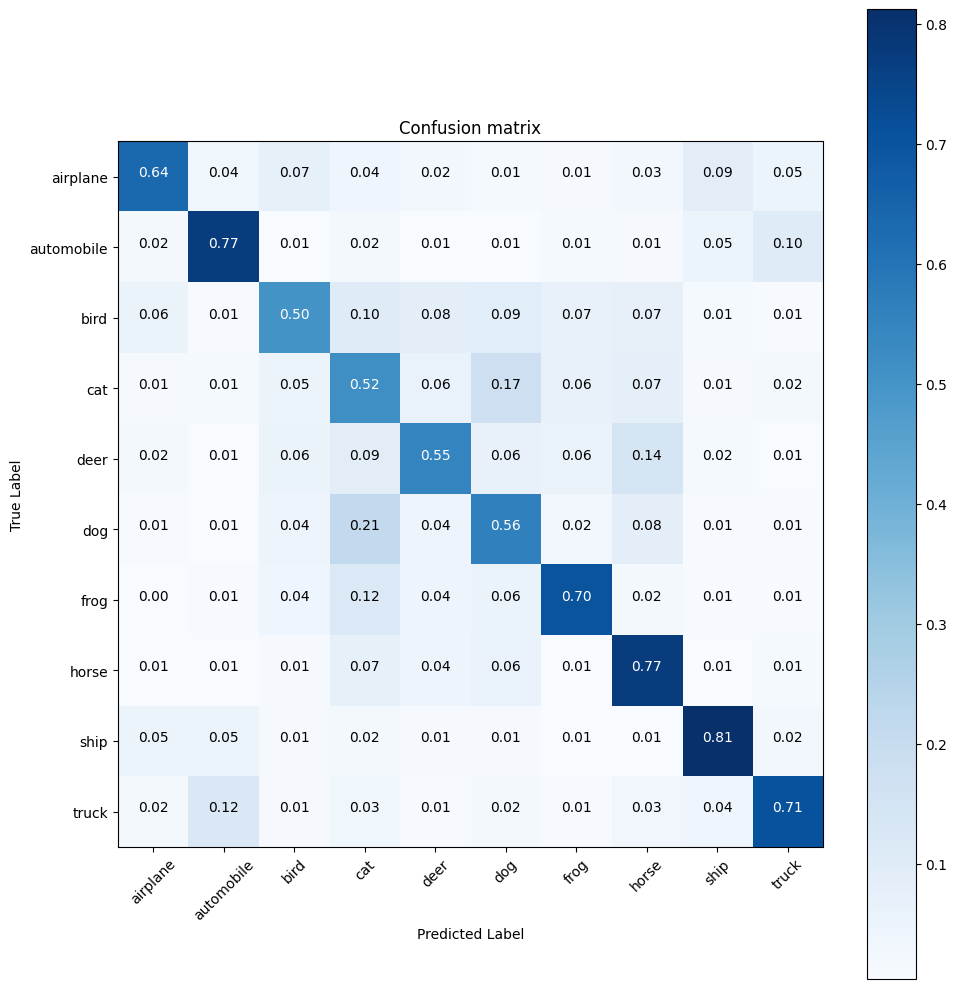

In [18]:
model_count += 1
# let's train something similar to Xception
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
]

model = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
)
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 39ms/step - loss: 1.9466 - sparse_accuracy: 0.2667 - val_loss: 1.4188 - val_sparse_accuracy: 0.4859
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - loss: 1.4434 - sparse_accuracy: 0.4730 - val_loss: 1.3246 - val_sparse_accuracy: 0.5185
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 36ms/step - loss: 1.3074 - sparse_accuracy: 0.5261 - val_loss: 1.1896 - val_sparse_accuracy: 0.5695
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - loss: 1.2116 - sparse_accuracy: 0.5610 - val_loss: 1.1486 - val_sparse_accuracy: 0.5880
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - loss: 1.1435 - sparse_accuracy: 0.5888 - val_loss: 1.1341 - val_sparse_accuracy: 0.5893
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - loss: 1.0959 - sparse_accuracy: 0.6084 - val_loss: 1.0617 - val_sparse_accuracy: 0.6184
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - loss: 1.0418 - sparse_accuracy: 0.6276 - val_loss: 1.0650 - val_sp

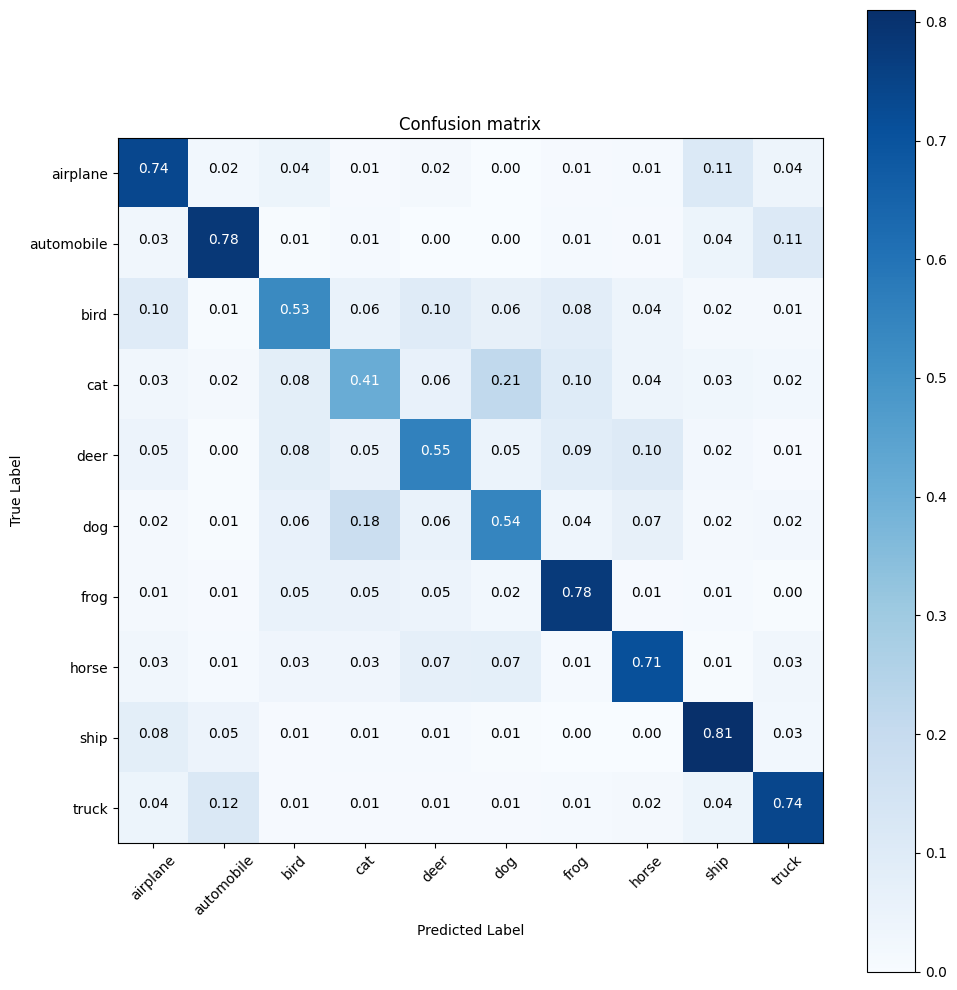

In [19]:
model_count += 1
# make even more similar to xception and add in dropout
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), strides=(2, 2), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
]

model = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
)
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 157s 98ms/step - loss: 1.5756 - sparse_accuracy: 0.4429 - val_loss: 1.1080 - val_sparse_accuracy: 0.6111
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 156s 100ms/step - loss: 0.9437 - sparse_accuracy: 0.6641 - val_loss: 0.9345 - val_sparse_accuracy: 0.6697
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - loss: 0.7214 - sparse_accuracy: 0.7460 - val_loss: 0.9371 - val_sparse_accuracy: 0.6818
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 124s 79ms/step - loss: 0.5611 - sparse_accuracy: 0.8070 - val_loss: 0.8749 - val_sparse_accuracy: 0.7050
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 107s 68ms/step - loss: 0.4109 - sparse_accuracy: 0.8625 - val_loss: 0.8957 - val_sparse_accuracy: 0.7070
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 105s 67ms/step - loss: 0.2874 - sparse_accuracy: 0.9106 - val_loss: 0.9218 - val_sparse_accuracy: 0.7128
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 124s 79ms/step - loss: 0.1904 - sparse_accuracy: 0.9458 - val_loss: 1.0009 

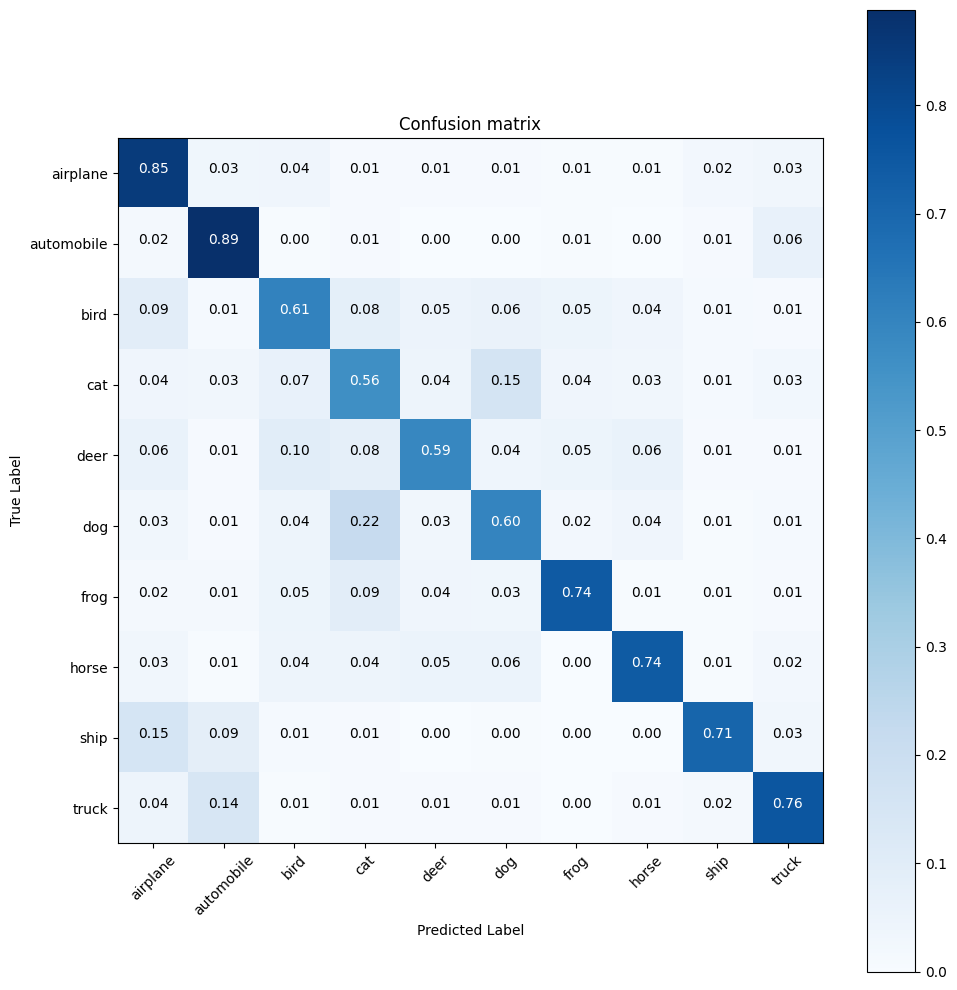

In [20]:
model_count += 1
# go back to one of our earlier models and add in batch normalization
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
]

model = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
)
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 62ms/step - loss: 2.1316 - sparse_accuracy: 0.2707 - val_loss: 1.4072 - val_sparse_accuracy: 0.4981
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 97s 62ms/step - loss: 1.5032 - sparse_accuracy: 0.4649 - val_loss: 1.1847 - val_sparse_accuracy: 0.5824
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 113s 72ms/step - loss: 1.2858 - sparse_accuracy: 0.5496 - val_loss: 1.0300 - val_sparse_accuracy: 0.6458
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 92ms/step - loss: 1.1160 - sparse_accuracy: 0.6116 - val_loss: 0.9718 - val_sparse_accuracy: 0.6707
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 137s 88ms/step - loss: 1.0159 - sparse_accuracy: 0.6509 - val_loss: 0.8869 - val_sparse_accuracy: 0.6980
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 134s 86ms/step - loss: 0.9362 - sparse_accuracy: 0.6749 - val_loss: 0.8403 - val_sparse_accuracy: 0.7182
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - loss: 0.8514 - sparse_accuracy: 0.7046 - val_loss: 0.8206 - v

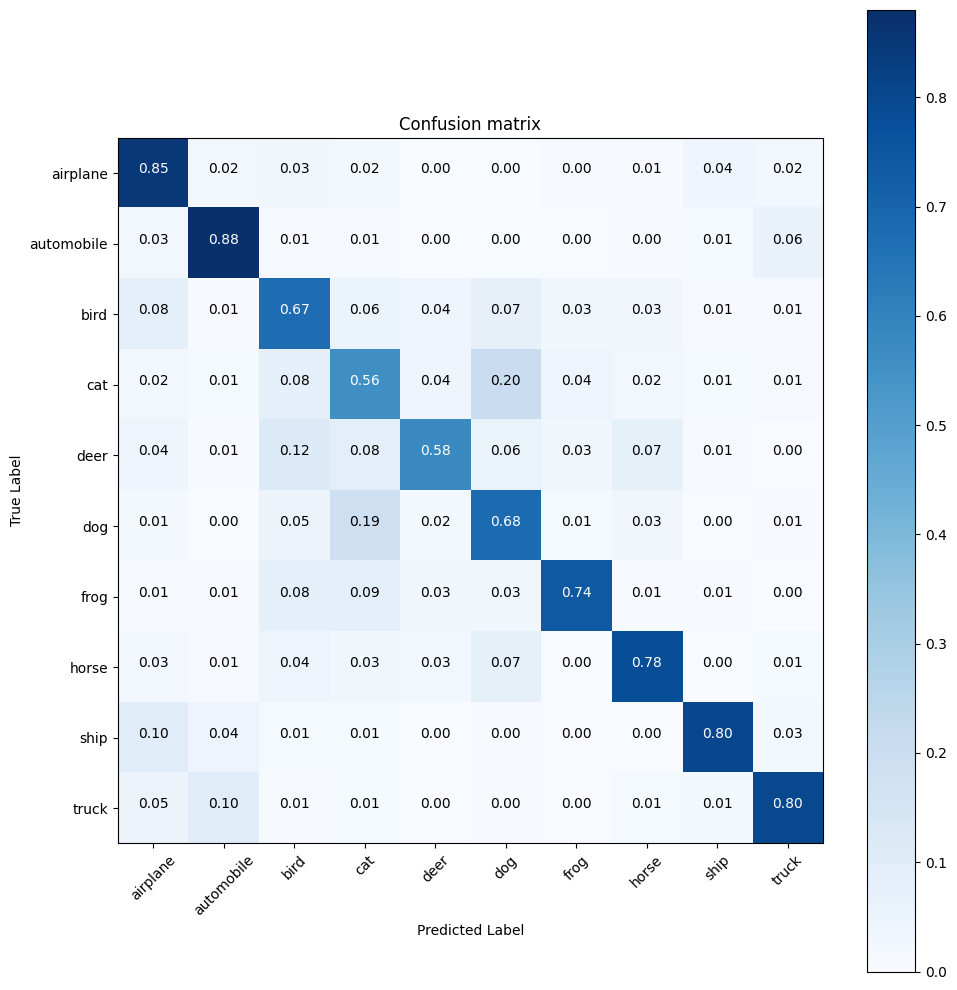

In [21]:
model_count += 1
# we've been overfitting pretty badly on the last few models, so let's add in some dropout
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
]

model = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
)
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 82ms/step - loss: 2.1569 - sparse_accuracy: 0.2579 - val_loss: 1.4309 - val_sparse_accuracy: 0.5041
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 121s 78ms/step - loss: 1.5537 - sparse_accuracy: 0.4445 - val_loss: 1.2175 - val_sparse_accuracy: 0.5707
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 114s 73ms/step - loss: 1.3449 - sparse_accuracy: 0.5267 - val_loss: 1.0864 - val_sparse_accuracy: 0.6201
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - loss: 1.1907 - sparse_accuracy: 0.5794 - val_loss: 1.0136 - val_sparse_accuracy: 0.6440
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - loss: 1.0715 - sparse_accuracy: 0.6257 - val_loss: 0.9506 - val_sparse_accuracy: 0.6669
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - loss: 0.9789 - sparse_accuracy: 0.6606 - val_loss: 0.8901 - val_sparse_accuracy: 0.6948
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - loss: 0.8874 - sparse_accuracy: 0.6911 - val_loss: 0.8451 - val

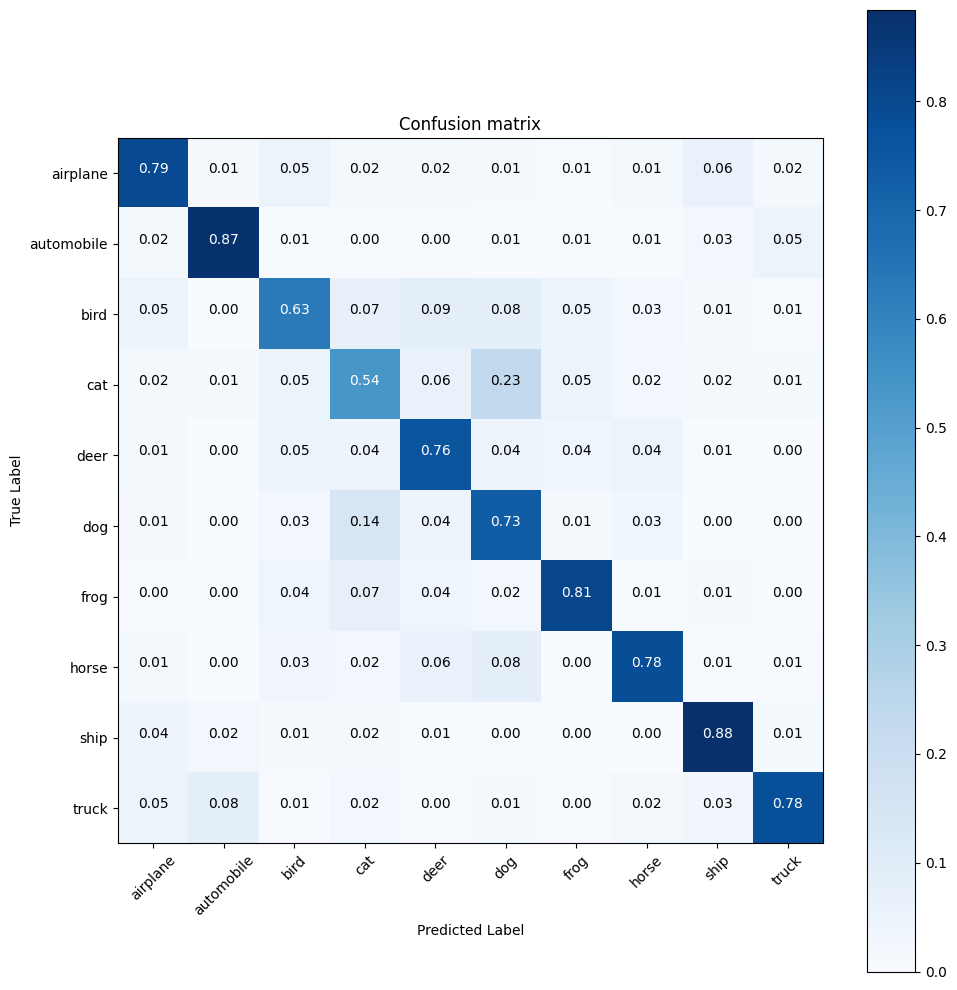

In [22]:
# that model has definitely worked the best so far with minimal overfitting, so let's increase the epochs
model_count += 1
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
]

model = ModelBuilder().build(core_layers, name=f"Model_{model_count}")

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
)
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 104s 65ms/step - loss: 2.2582 - sparse_accuracy: 0.2156 - val_loss: 1.6247 - val_sparse_accuracy: 0.4153
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 102s 65ms/step - loss: 1.8150 - sparse_accuracy: 0.3506 - val_loss: 1.4715 - val_sparse_accuracy: 0.4734
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 102s 65ms/step - loss: 1.6930 - sparse_accuracy: 0.3923 - val_loss: 1.4395 - val_sparse_accuracy: 0.4819
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 102s 65ms/step - loss: 1.5901 - sparse_accuracy: 0.4313 - val_loss: 1.3644 - val_sparse_accuracy: 0.5100
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 102s 65ms/step - loss: 1.5147 - sparse_accuracy: 0.4617 - val_loss: 1.3415 - val_sparse_accuracy: 0.5257
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 102s 65ms/step - loss: 1.4659 - sparse_accuracy: 0.4839 - val_loss: 1.2683 - val_sparse_accuracy: 0.5588
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 102s 65ms/step - loss: 1.4161 - sparse_accuracy: 0.5012 - val_loss: 1.1886 -

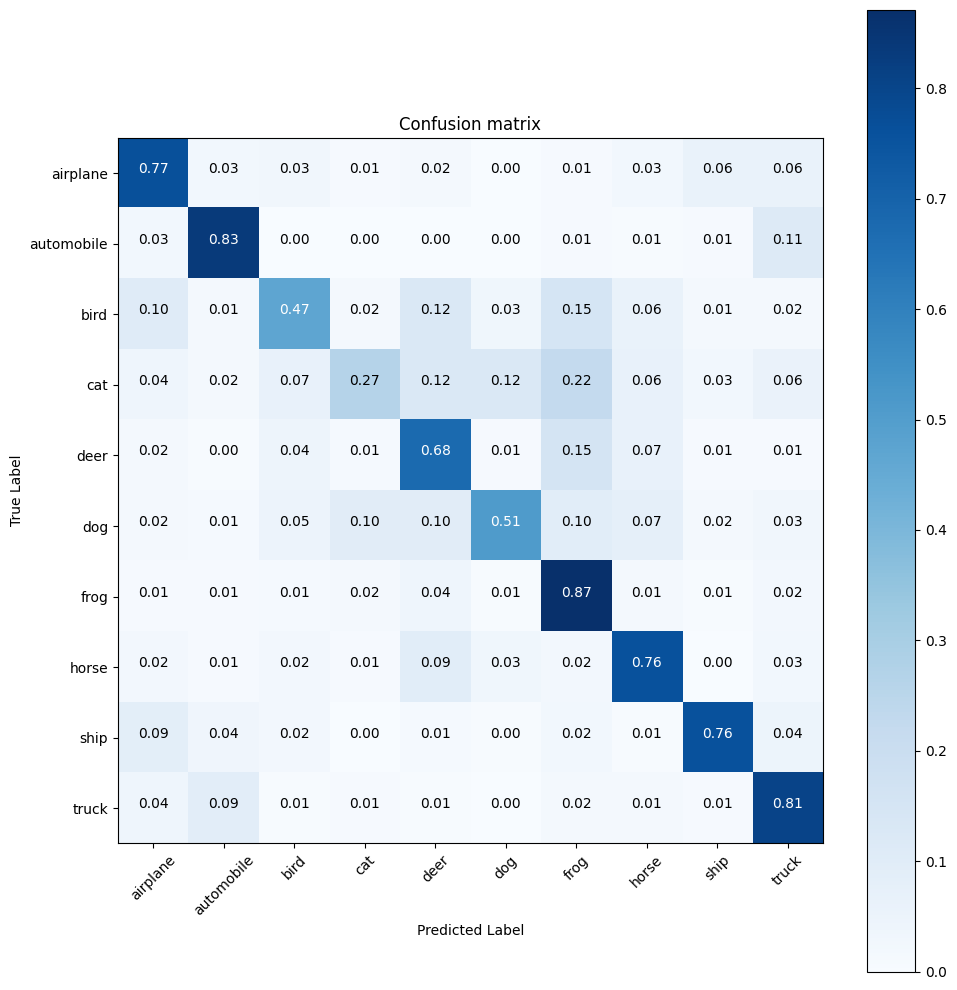

In [23]:
# we're beginning to see some overfitting, so let's add in some data augmentation
model_count += 1
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
]

# augmentation is added in the ModelBuilder class
model = ModelBuilder().augmentation().build(core_layers, name=f"Model_{model_count}")

# add in early stopping as well
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 134s 84ms/step - loss: 2.3063 - sparse_accuracy: 0.2055 - val_loss: 1.6092 - val_sparse_accuracy: 0.4173
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - loss: 1.8336 - sparse_accuracy: 0.3415 - val_loss: 1.4922 - val_sparse_accuracy: 0.4606
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - loss: 1.6796 - sparse_accuracy: 0.4016 - val_loss: 1.4047 - val_sparse_accuracy: 0.5019
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - loss: 1.5955 - sparse_accuracy: 0.4333 - val_loss: 1.3519 - val_sparse_accuracy: 0.5100
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - loss: 1.4939 - sparse_accuracy: 0.4687 - val_loss: 1.2620 - val_sparse_accuracy: 0.5590
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 132s 84ms/step - loss: 1.4300 - sparse_accuracy: 0.4956 - val_loss: 1.2336 - val_sparse_accuracy: 0.5585
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - loss: 1.3643 - sparse_accuracy: 0.5190 - val_loss: 1.2263 -

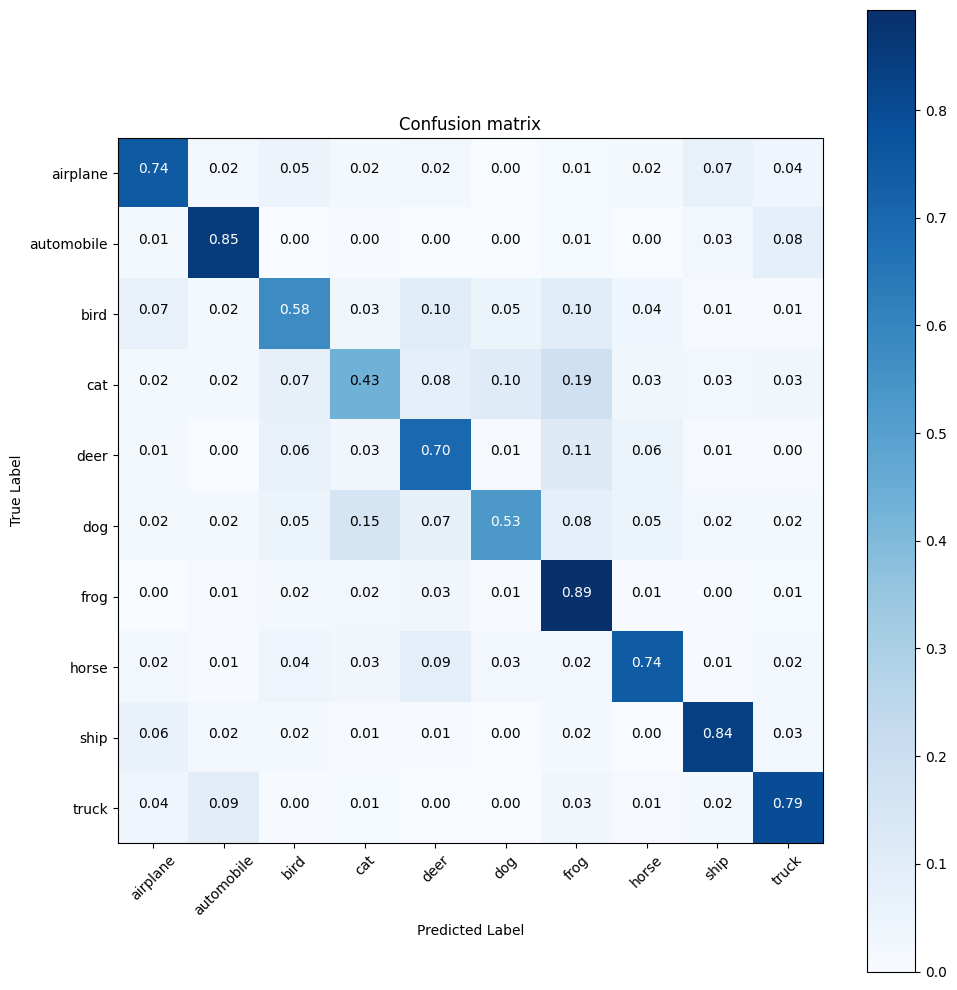

In [24]:
# it looks like we're no longer overfitting, but our accuracy seems to have plateaued
# let's try adding in some more layers
model_count += 1
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
]

model = ModelBuilder().augmentation().build(core_layers, name=f"Model_{model_count}")

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 107s 67ms/step - loss: 2.0412 - sparse_accuracy: 0.2723 - val_loss: 1.5809 - val_sparse_accuracy: 0.4349
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 105s 67ms/step - loss: 1.6208 - sparse_accuracy: 0.4208 - val_loss: 1.4077 - val_sparse_accuracy: 0.4963
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 105s 67ms/step - loss: 1.5068 - sparse_accuracy: 0.4585 - val_loss: 1.3717 - val_sparse_accuracy: 0.5148
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 104s 67ms/step - loss: 1.4055 - sparse_accuracy: 0.4983 - val_loss: 1.1988 - val_sparse_accuracy: 0.5706
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 104s 67ms/step - loss: 1.3210 - sparse_accuracy: 0.5255 - val_loss: 1.1662 - val_sparse_accuracy: 0.5820
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 105s 67ms/step - loss: 1.2651 - sparse_accuracy: 0.5516 - val_loss: 1.2084 - val_sparse_accuracy: 0.5761
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 104s 67ms/step - loss: 1.2207 - sparse_accuracy: 0.5679 - val_loss: 1.0901 -

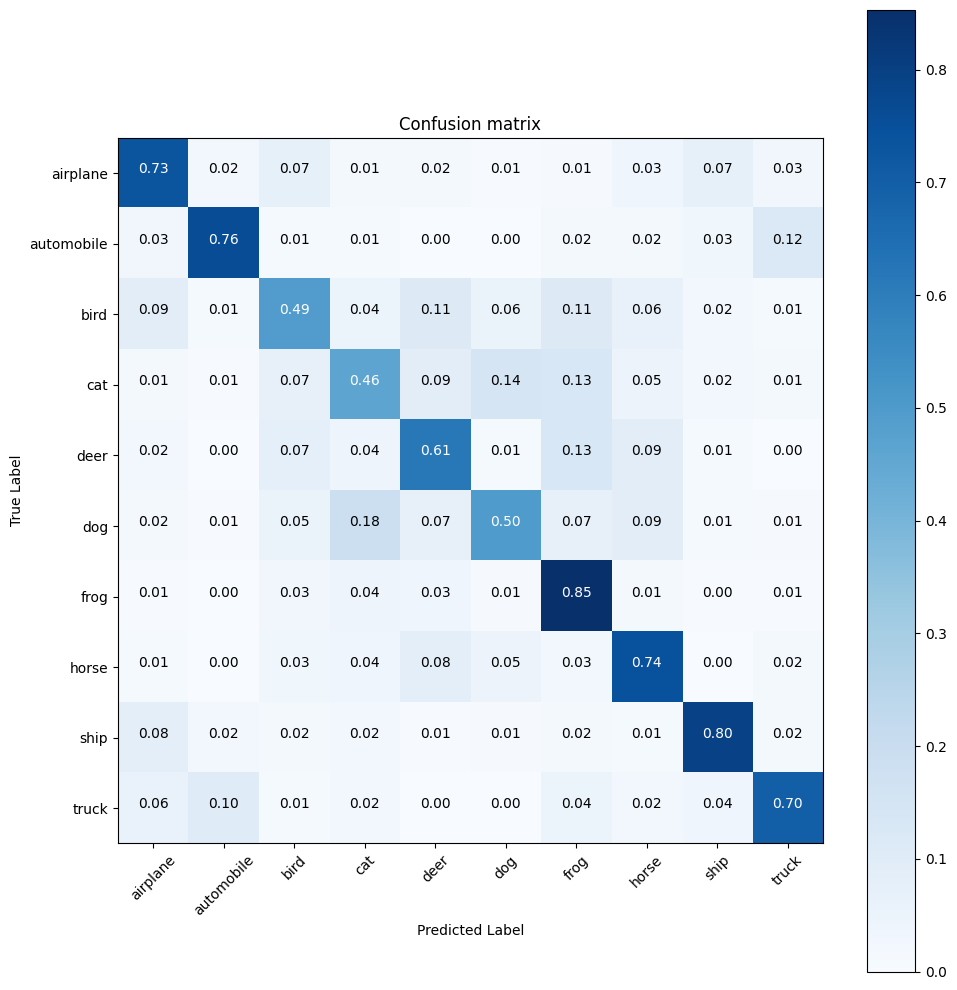

In [25]:
model_count += 1
# we got diminishing returns pretty quickly
# let's remove batch normalization layers and decrease dropout
core_layers = [
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
]

model = ModelBuilder().augmentation().build(core_layers, name=f"Model_{model_count}")

# add in early stopping as well
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)
plot_confusion_matrix(y_test, X_test, model, classes)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 78s 50ms/step - loss: 1.0669 - sparse_accuracy: 0.6234 - val_loss: 1.0005 - val_sparse_accuracy: 0.6496
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 130s 83ms/step - loss: 1.0349 - sparse_accuracy: 0.6354 - val_loss: 1.0519 - val_sparse_accuracy: 0.6310
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 128s 82ms/step - loss: 1.0103 - sparse_accuracy: 0.6451 - val_loss: 0.9011 - val_sparse_accuracy: 0.6854
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - loss: 0.9781 - sparse_accuracy: 0.6559 - val_loss: 1.1838 - val_sparse_accuracy: 0.5961
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 129s 82ms/step - loss: 0.9601 - sparse_accuracy: 0.6631 - val_loss: 0.9992 - val_sparse_accuracy: 0.6584
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 89s 57ms/step - loss: 0.9273 - sparse_accuracy: 0.6764 - val_loss: 0.9494 - val_sparse_accuracy: 0.6742
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 137s 88ms/step - loss: 0.9201 - sparse_accuracy: 0.6749 - val_loss: 0.8628 - va

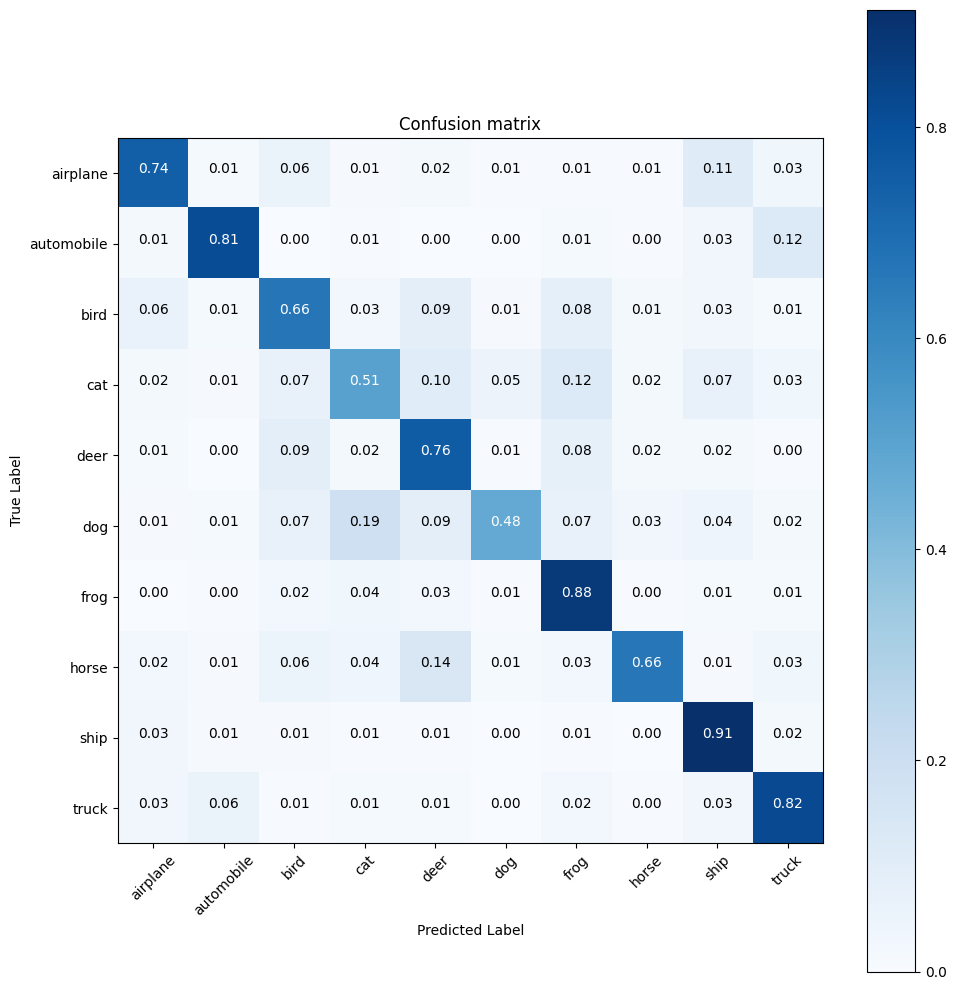

In [27]:
# that model was doing pretty well, so let's try increasing the epochs
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)
plot_confusion_matrix(y_test, X_test, model, classes)

In [26]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")

Notebook last run (end-to-end): 2025-04-28 05:51:13.601770 (duration: 5:39:12.022100)
